In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
from scipy.sparse import coo_matrix, hstack
import re, unicodedata
import os

from sklearn.utils import shuffle

from nltk.stem import WordNetLemmatizer
from tokenizer import tokenize

from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import shuffle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
import pyspark
import matplotlib.pyplot as plt
from collections import Counter

/Users/jianhenghou/anaconda2/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def read_files(path):
    train_pos_files = os.listdir(path)
    raw_text = []
    for filename in train_pos_files:
        fb = open(path+filename,'r')
        raw_text.append(fb.readline())
        fb.close()  
    return raw_text

In [3]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "havent":"have not","haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def normalize(words):
    word_list = []
    for word in words:
        """Remove non-ASCII characters from list of tokenized words"""
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        """Convert all characters to lowercase from list of tokenized words"""
        new_word = new_word.lower()
        """Remove punctuation except for "?" and "!" from list of tokenized words"""
        if contraction_mapping.__contains__(new_word):
            new_word = contraction_mapping[new_word]
        new_word = re.sub(r'[^\w\s!?]', '', new_word)
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        new_word = lemmatizer.lemmatize(new_word, pos='v')
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        if new_word.isdigit():
            new_word = 'digit'
        if new_word != '':
            word_list.append(new_word)
    return word_list

# Loading the Data

Read train data and test data from files

In [4]:
# read all train data
train_pos = read_files('./aclImdb/train/pos/')
train_neg = read_files('./aclImdb/train/neg/')
raw_train_text = train_pos + train_neg
train_label = [1] * len(train_pos) + [0] * len(train_neg)
raw_train_text, train_label = shuffle(raw_train_text, train_label, random_state=0)

# read all test data
test_pos = read_files('./aclImdb/test/pos/')
test_neg = read_files('./aclImdb/test/neg/')
raw_test_text = test_pos + test_neg
test_label = [1] * len(test_pos) + [0] * len(test_neg)
raw_test_text, test_label = shuffle(raw_test_text, test_label, random_state=0)

raw_corpus_text = raw_train_text + raw_test_text

# Preprocessing the text

Preprocessing for train text

In [5]:
train_text = []
for each in raw_train_text:
    tmp = each.replace('-', ' ').replace('<br />',"")
    train_text.append("".join(word + ' ' for word in normalize([word.txt for word in tokenize(tmp) if word.txt != None])).strip())
test_text = []
for each in raw_test_text:
    tmp = each.replace('-', ' ').replace('<br />',"")
    test_text.append("".join(word + ' ' for word in normalize([word.txt for word in tokenize(tmp) if word.txt != None])).strip())
processed_corpus_text = train_text + test_text

Write corpus into a file

In [6]:
# with open('IMDB_raw_corpus_text.txt','w') as c:
#     for line in raw_corpus_text:
#         c.write(line + '\n')
#     c.close()
# with open('IMDB_raw_train_text.txt','w') as tr:
#     for line in train_text:
#         tr.write(line + '\n')
#     tr.close()
# with open('IMDB_raw_test_text.txt','w') as te:
#     for line in test_text:
#         te.write(line + '\n')
#     te.close()

# Data Analysis

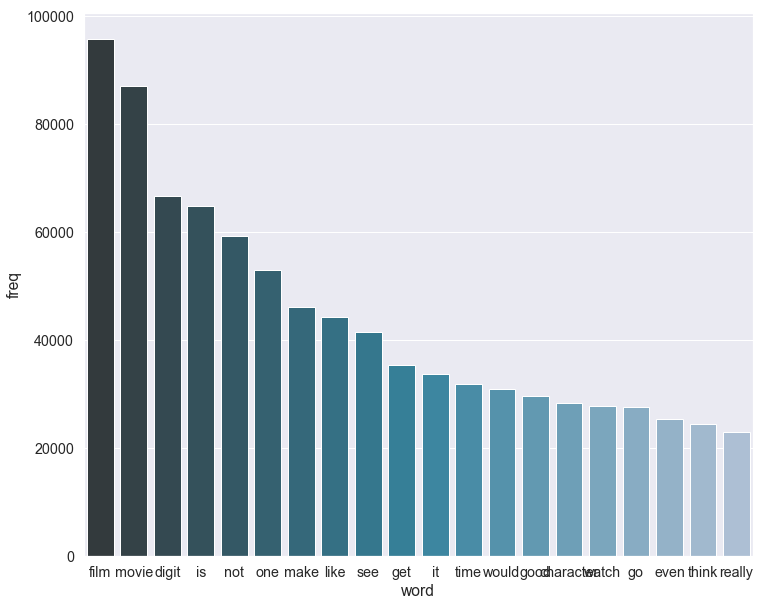

In [64]:
def normalize_analysis(words):
    contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "havent":"have not","haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
    stop_words = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

    word_list = []
    for word in words:
        """Remove non-ASCII characters from list of tokenized words"""
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        """Convert all characters to lowercase from list of tokenized words"""
        new_word = new_word.lower()
        """Remove punctuation except for "?" and "!" from list of tokenized words"""
        if contraction_mapping.__contains__(new_word):
            new_word = contraction_mapping[new_word]
        new_word = re.sub(r'[^\w\s!?]', '', new_word)
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        new_word = lemmatizer.lemmatize(new_word, pos='v')
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        if new_word.isdigit():
            new_word = 'digit'
        if new_word in stop_words:
            new_word = ''
        if new_word != '':
            word_list.append(new_word)
    return word_list

text_analysis = []
for each in raw_corpus_text:
    tmp = each.replace('-', ' ').replace('<br />',"")
    text_analysis.append("".join(word + ' ' for word in normalize_analysis([word.txt for word in tokenize(tmp) if word.txt != None])).strip())

from sklearn.feature_extraction.text import CountVectorizer
import collections
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

cv = CountVectorizer()
bow = cv.fit_transform(text_analysis)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

Take a look at the train text

In [7]:
train_df = pd.DataFrame(list(zip(raw_train_text,train_text, train_label)), columns =['raw_text','text', 'sentiment'])
test_df = pd.DataFrame(list(zip(raw_test_text,test_text, test_label)), columns =['raw_text','text', 'sentiment'])
# pd.set_option('display.max_colwidth', 500)
test_df.loc[[173]]

,raw_text,text,sentiment
173,"First off, I am a huge fan of Tolkien, and as one I will base most of my critic on his books.<br /><br />The movie is a standard adventure movie, well made with nifty special effects, nice sound track and fine acting. Now if this movie was called something else than lord of the rings the reviews wouldn't be half this good as they are here.<br /><br />The problem of the movie is that it takes the basic story line from Tolkiens books but then it goes and ""hollywoods"" everything it can, numerous scenes from the book are eighter missing or changed quite a lot, the characters are changed from the book also, a thing that I think should be punishable ! What the movie lacks is deep insight of the characters in it, I know that it is almost impossible to make a good film out of a good book, and it didn't work here eighter, mostly the motivation of the characters is left hazy at best.<br /><br />As a adventure movie it would rate 7+ / 10 As a adaptation of Tolkien it rates 2 / 10<br /><br />I mean honestly, what on earth was Arwen doing at rivendell ford ? And as for the comments that this movie ""is the best ever"" I can only say that eighter you are very young, or you havent seen good movies...<br /><br />Peter Jackson should have called this movie an adventure movie based on the lord of the rings.",first off i be a huge fan of tolkien and as one i will base most of my critic on his book the movie be a standard adventure movie well make with nifty special effect nice sound track and fine act now if this movie be call something else than lord of the ring the review would not be half this good as they be here the problem of the movie be that it take the basic story line from tolkiens book but then it go and hollywoods everything it can numerous scenes from the book be eighter miss or change quite a lot the character be change from the book also a thing that i think should be punishable ! what the movie lack be deep insight of the character in it i know that it be almost impossible to make a good film out of a good book and it did not work here eighter mostly the motivation of the character be leave hazy at best as a adventure movie it would rate digit digit as a adaptation of tolkien it rat digit 10i mean honestly what on earth be arwen do at rivendell ford ? and as for the comment that this movie be the best ever i can only say that eighter you be very young or you have not see good movies peter jackson should have call this movie an adventure movie base on the lord of the ring,0


# Word Embedding

## TF-IDF

Train TF-IDF embedding

In [85]:
stop_words_list = ["he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "a", "an", "the", "and", "of", "at", "by", "for", "with", "about", "into", "through", "during", "to", "from", "then", "once", "here", "there", "both", "each",  "some", "such","own", "than", "don", "now"]
Tfidf_vectorizer = TfidfVectorizer(max_features=10000,
                                   min_df=2, 
                                   ngram_range=(1, 3),
                                   analyzer='word',
                                   stop_words = stop_words_list)

Tfidf_vectorizer.fit(processed_corpus_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=2,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'a', 'an', 'the', 'and', 'of', 'at', 'by', 'for', 'with', 'about', 'into', 'through', 'during', 'to', 'from', 'then', 'once', 'here', 'there', 'both', 'each', 'some', 'such', 'own', 'than', 'don', 'now'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Transform the train/test text into the corresponding TF-IDF embedding

In [87]:
train = Tfidf_vectorizer.transform(train_text)
test = Tfidf_vectorizer.transform(test_text)

# Feature Engineering

In [11]:

def add_features(text_list):
    # length feature     
    feature_length = []
    # 'i' count feature
    feature_i_count = []
    for line in text_list:
        cnt = Counter()
        tokenzied = [word.txt for word in tokenize(line) if word.txt != None]
        for word in tokenzied:
            if word == 'i':
                cnt['i'] += 1
        feature_i_count.append(cnt['i'])
        feature_length.append(len(tokenzied))
    return feature_length, feature_i_count

def add_pos_neg_weights(text_list, label):
    # word pos/neg weight   
    conf = SparkConf() \
            .setAppName("add_pos_neg_weight") \
            .set("spark.driver.host", "localhost")
    sc = SparkContext(conf=conf)
    text_RDD = sc.parallelize(list(zip(text_list, label)))
    
    pos_dict = text_RDD.filter(lambda x: x[1] == 1)\
                        .flatMap(lambda x: x[0].split(" "))\
                                .map(lambda x: (x, 1))\
                                    .reduceByKey(lambda a, b: a + b)\
                                            .collectAsMap()
    neg_dict = text_RDD.filter(lambda x: x[1] == 0)\
                            .flatMap(lambda x: x[0].split(" "))\
                                    .map(lambda x: (x, 1))\
                                            .reduceByKey(lambda a, b: a + b)\
                                                    .collectAsMap()
#     whole_RDD = pos_RDD.union(neg_RDD).reduceByKey(lambda x,y : x+y).map(lambda x: (x[0], (x[1] + 2)**2))    
#     word_sentiment_weight = whole_RDD.collectAsMap()
    sc.stop()
    word_sentiment_weight = {}
    all_words = set(pos_dict.keys()).union(set(neg_dict.keys()))
    for key in all_words:
        if key is not pos_dict:
            pos_dict[key] = 0
        if key is not neg_dict:
            neg_dict[key] = 0
        N = pos_dict[key] + neg_dict[key]
        if key == 'ponyo':
            print('yes')
        word_sentiment_weight[key] = float((N + 2)**2) / ((pos_dict[key] + 1) * (neg_dict[key] + 1))

    return word_sentiment_weight

In [29]:
# # new features: feat_len, feat_i
# feat_len_train, feat_i_train = add_features(train_text)
# feat_len_test, feat_i_test = add_features(test_text)

# # sentiment weights for each word
# from pyspark import SparkContext, SparkConf
# feat_sentiment_weight = add_pos_neg_weights(train_text, train_label)

In [13]:
# feat_sentiment_weight_list = []
# for feature_name in Tfidf_vectorizer.get_feature_names():
#     if feature_name not in feat_sentiment_weight:
#         feat_sentiment_weight_list.append(1)
#     else:
#         feat_sentiment_weight_list.append(feat_sentiment_weight[feature_name])

In [31]:
# # adding new features if neccessary
# boosted_train = train.toarray() * np.array(feat_sentiment_weight_list)
# boosted_test = test.toarray() * np.array(feat_sentiment_weight_list)
# boosted_train = np.c_[boosted_train, feat_len_train, feat_i_train] 
# boosted_test = np.c_[boosted_test, feat_len_test, feat_i_test] 

# Building Classifiers

##  SentimentIntensityAnalyzer

In [54]:
# Analysis using NLTK Vader SentimentAnalyser
sia = SentimentIntensityAnalyzer()
for train
sia_y_pred_train = []
for sentence in train_text:
        ss = sia.polarity_scores(sentence)
        if ss['compound'] >= 0.4:
            sia_y_pred_train.append(1)
        elif ss['compound'] <= -0.4:
            sia_y_pred_train.append(-1)
        else:
            sia_y_pred_train.append(0)

print(classification_report(test_label, sia_y_pred_train))
print("Accuracy:", balanced_accuracy_score(test_label, sia_y_pred_train))

#  for test
sia_y_pred_test = []
value = []
for sentence in test_text:
        ss = sia.polarity_scores(sentence)
        value.append(ss['compound'])
        if ss['compound'] > 0.3:
            sia_y_pred_test.append(1)
        else:
            sia_y_pred_test.append(0)
print(classification_report(test_label, sia_y_pred_test))
print("Accuracy:", balanced_accuracy_score(test_label, sia_y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66     12500
           1       0.66      0.84      0.74     12500

   micro avg       0.70      0.70      0.70     25000
   macro avg       0.72      0.70      0.70     25000
weighted avg       0.72      0.70      0.70     25000

Accuracy: 0.7045600000000001


## Logist Regression

## Classifiers

In [47]:
#  best {'C': 1, 'penalty': 'l2'} for train
#  best {'C': 0.1, 'penalty': 'l2'} for boosted_train
param_grid = dict(C=[0.01, 0.1, 1], penalty =['l1','l2'])

grid = GridSearchCV(LogisticRegression(), 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring=['f1', 'roc_auc', 'balanced_accuracy'], 
                    refit='f1',
                    n_jobs=-1)
grid.fit(train, train_label)
LR_model = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'penalty': 'l2'}
0.8949228944646784


In [48]:
LR_y_pred = LR_model.predict(test)
print("==========Model Evalucation=========")
print(classification_report(test_label, LR_y_pred))
print("============Test Accuracy===========")
print(balanced_accuracy_score(test_label, LR_y_pred))

==========Model Evalucation=========
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     12500
           1       0.89      0.90      0.90     12500

   micro avg       0.90      0.90      0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

============Test Accuracy===========
0.8957200000000001


## Support Vector Machine

In [49]:
# {'C': 4, 'gamma': 1, 'kernel': 'rbf'} forr 10000, 1
# {'C': 4, 'gamma': 1, 'kernel': 'rbf'} for 30000, 1-5
param_grid = dict(gamma=[1], C=[1, 2, 4], kernel=['rbf'])
grid = GridSearchCV(SVC(), 
                    param_grid=param_grid, 
                    scoring=['f1'], 
                    refit='f1',
                    n_jobs=-1)
grid.fit(train, train_label)
SVM_model = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)

{'C': 4, 'gamma': 1, 'kernel': 'rbf'}
0.9001096993221857


In [51]:
SVM_y_pred = SVM_model.predict(test)
print("==========Model Evalucation=========")
print(classification_report(test_label, SVM_y_pred))
print("============Test Accuracy===========")
print(balanced_accuracy_score(test_label, SVM_y_pred))

==========Model Evalucation=========
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12500
           1       0.90      0.90      0.90     12500

   micro avg       0.90      0.90      0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

============Test Accuracy===========
0.90036


## Random Forest

In [93]:
#  best {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 200, 'oob_score': True}
param_grid = dict(n_estimators=[200], criterion=["entropy"], oob_score=[True],max_depth=[40])

grid = GridSearchCV(RandomForestClassifier(), 
                    param_grid=param_grid, 
                    scoring=['f1'], 
                    refit='f1',
                    n_jobs=-1)
grid.fit(train, train_label)
RF_model = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 200, 'oob_score': True}
0.8519883770473496


In [94]:
RF_y_pred = RF_model.predict(test)
print("==========Model Evalucation=========")
print(classification_report(test_label, RF_y_pred))
print("============Test Accuracy===========")
print(balanced_accuracy_score(test_label, RF_y_pred))

==========Model Evalucation=========
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     12500
           1       0.84      0.87      0.86     12500

   micro avg       0.85      0.85      0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000

============Test Accuracy===========
0.8546


check feature importance

In [97]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(20,20), print_table=False, title="Feature Importances"):
    __name__ = "plot_feature_importances"
    
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

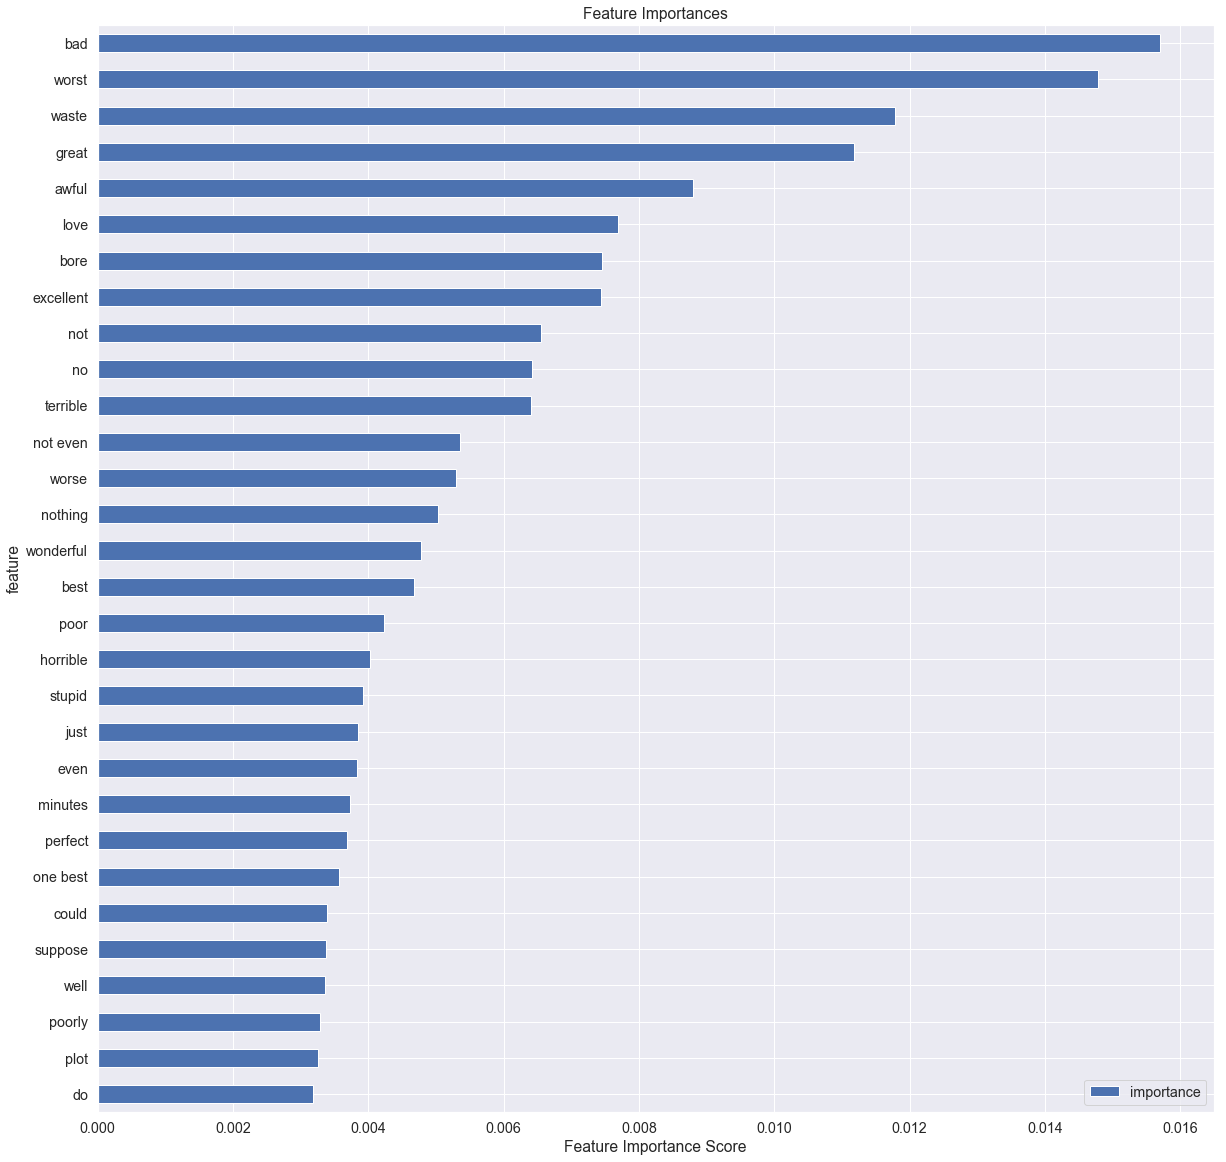

In [98]:
X_train = pd.DataFrame(train.toarray(), columns=Tfidf_vectorizer.get_feature_names())
y_train = pd.DataFrame(train_label)
_ = plot_feature_importances(RF_model, X_train, y_train, top_n=30)

## XGBoost

In [58]:
# 2000 best
#  {'n_estimators': 3000} for 30000, 1-5 gram
cv_params = {'n_estimators': [2000, 3000, 4000]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,
                'early_stopping_rounds': 20}
xgb_model = xgb.XGBClassifier(**other_params)
grid = GridSearchCV(xgb_model, 
                    param_grid=cv_params, 
                    scoring=['f1'], 
                    refit='f1',
                    n_jobs=-1)
grid.fit(train, train_label)
XGBoost_model = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 3000}
0.8788980982857951


In [59]:
xgb_y_pred = XGBoost_model.predict(test)
print("==========Model Evalucation=========")
print(classification_report(test_label, xgb_y_pred))
print("============Test Accuracy===========")
print(balanced_accuracy_score(test_label, xgb_y_pred))

==========Model Evalucation=========
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12500
           1       0.88      0.89      0.89     12500

   micro avg       0.89      0.89      0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

============Test Accuracy===========
0.88556


## Ensembled model (SVM + LR + SIA)

In [57]:
test_df = pd.DataFrame(list(zip(test_text,test_label, LR_y_pred, SVM_y_pred, sia_y_pred_test)), columns =['test_text','true_label', 'LR_predict','SVM_predict', 'SIA_predict'])
test_df.head(3)

,test_text,true_label,LR_predict,SVM_predict,SIA_predict
0,like many western pennsylvania history buff i have be really look forward to this much herald pbs program that be produce by pittsburghs wqed however i must say now that i be somewhat disappoint on the positive side i believe that overall this film do a fair job of explain the main issue and describe the events of the so call french and indian war in particular its presentation of the indians point of view be somewhat new and quite interest although it certainly be at time over emphasize also on the positive side the blend of narrative and action scenes be well do and come across somewhat better than many of these typical documentaries make up of experts interview and picture still a la ken burn on the negative side many of the battle do have a somewhat stag look and many important aspects of the war be overlook most of all i be very disappoint and frustrate by how little importance be give to forbess successful campaign of digit against fort duquesne as compare to the earlier failures of digit by washington and digit by braddock in particular i be somewhat incredulous that there be no mention of colonel henry bouquet the swiss mercenary in the british service who be most responsible for forbes success finally i could not believe the complete omission of the digit battle of bushy run that start as a re run of braddocks defeat but end up as the victory that decide the outcome of pontiacs war thank to the wiles of the same colonel bouquet who certainly must rank as one of the most successful british commanders of this war,0,1,1,0
1,there is a brand new killer on the loose and he is do gods work yeah right ! this killer make jason voorhes look like a chump and freddy krueger look like a rag doll against this dude he be jacob goodnight wwes glen kane jacobs a digit monster who wield a axe and a hook and chain those weapons be nothing to him his real finisher be rip out eyeball from the victims sockets that be totally methodical ! when the encounter happen digit years earlier jacob kill a rookie cop and maim the veteran after put a bullet in his head how on earth do goodnight survive after digit years ? now he is in the condemn hotel call blackwell and this hotel get a lot of stories to tell i think this movie be haunt as well as interest i like the part where goodnight check out one of the girls tattoo on her back and goodnight himself be really derange thank to his maniacal mother if you think friday the digit th be something you better think again this movie will leave you on the edge of you seat and i think the eyeball rip be bone chill this movie prove it point and it was not a waste of my time i enjoy it the title do not lie ! rat digit out of digit star !,1,0,0,0
2,as if the world had not already get enough cheap jaw imitations writer boaz davidson decide to make the sequel to his ropey but reasonably enjoyable creature feature octopus a complete rip off of spielbergs classic right down to have a concern cop who no one believe and a mayor more worry about his digit th july celebrations than people live even in the hand of an extremely skilled director it be unlikely that this derivative rubbish could have be anything other than hokey b movie garbage but with yossi wein yes the yossi wein ! call the shots behind the camera a man with a fraction of mrspielbergs talent i estimate about digit digit th octopus digit be guarantee to be every bite as bad as one might imagine ! the predictable and extremely cliched plot is not worth describe in much detail substitute jaw amity island with new york and bruce the shark with a giant rubber octopus and you will get the gist although several point about the film be definitely worth mention simply because they be so funny all of the octopus attack involve the actors struggle to make incredibly fake look giant tentacles look real which be hilarious to behold bulgarias capital sofia unconvincingly stand in for new york and overuse o

In [56]:
ensemble_predict = []
for each in zip(SVM_y_pred, LR_y_pred, value):
    if sum(each) > 1:
        ensemble_predict.append(1)
    else:
        ensemble_predict.append(0)

print(classification_report(test_label, ensemble_predict))
print(balanced_accuracy_score(test_label, ensemble_predict))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     12500
           1       0.89      0.91      0.90     12500

   micro avg       0.90      0.90      0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

0.89832


In [17]:
NB_y_pred = NB_model.predict(test.toarray())
print("==========Model Evalucation=========")
print(classification_report(test_label, NB_y_pred))
print("============Test Accuracy===========")
print(balanced_accuracy_score(test_label, NB_y_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76     12500
           1       0.77      0.72      0.75     12500

   micro avg       0.75      0.75      0.75     25000
   macro avg       0.76      0.75      0.75     25000
weighted avg       0.76      0.75      0.75     25000

0.7543599999999999


## FastText

Logistic Regression

In [41]:
train = []
with open('IMDB_train_skipgram.txt') as tr_ft:
    for line in tr_ft.readlines():
        train.append([float(each) for each in line.strip().split()])
test = []
with open('IMDB_test_skipgram.txt') as te_ft:
    for line in te_ft.readlines():
        test.append([float(each) for each in line.strip().split()])

In [42]:
param_grid = dict(C=[0.01, 0.1, 1], penalty =['l1','l2'])

grid = GridSearchCV(LogisticRegression(), 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring=['f1', 'roc_auc', 'balanced_accuracy'], 
                    refit='f1',
                    n_jobs=-1)
grid.fit(train, train_label)
Fxt_LR_model = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'penalty': 'l1'}
0.8586571799835462


In [43]:
Fxt_LR_y_pred = Fxt_LR_model.predict(test)
print(classification_report(test_label, Fxt_LR_y_pred))
print(balanced_accuracy_score(test_label, Fxt_LR_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

   micro avg       0.86      0.86      0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

0.8624


In [45]:
param_grid = dict(gamma=[1], C=[4], kernel=[ 'rbf'])

grid = GridSearchCV(SVC(), 
                    param_grid=param_grid, 
                    scoring=['f1'], 
                    refit='f1',
                    n_jobs=-1)
grid.fit(train, train_label)
Fxt_SVM_model = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)

{'C': 4, 'gamma': 1, 'kernel': 'rbf'}
0.8671051176527236


In [ ]:
Fxt_SVM_y_pred = Fxt_SVM_model.predict(test)
print(classification_report(test_label, Fxt_SVM_y_pred))
print(balanced_accuracy_score(test_label, Fxt_SVM_y_pred))